<a href="https://colab.research.google.com/github/AndrewLCA/CSE-158-Spoiler/blob/main/CSE_158_Spoiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_reviews_spoiler.json.gz

--2024-12-02 20:49:54--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_reviews_spoiler.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 620474664 (592M) [application/x-gzip]
Saving to: ‘goodreads_reviews_spoiler.json.gz.1’

goodreads_reviews_s 100%[===================>] 591.73M  80.9MB/s    in 15s     

2024-12-02 20:50:09 (38.8 MB/s) - ‘goodreads_reviews_spoiler.json.gz.1’ saved [620474664/620474664]



In [ ]:
import json
import gzip
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pprint import pp

In [ ]:
#################################################
# Read in Dataset                               #
#################################################

In [ ]:
filename = "goodreads_reviews_spoiler.json.gz"
all_data = []
# max_count = 30000
# count = 0
with gzip.open(filename, 'rt') as f:
  for line in f:
    all_data.append(json.loads(line))


In [ ]:


#split dataset in half to parse train/test sets
raw_test_data, raw_train_data = train_test_split(all_data, test_size=0.5, random_state=42)

#select train size = 40000, test size = 5000
#half are spoilers, half are non-spoilers
trainData = []
numSpoilerTrain = 0
numNonSpoilerTrain = 0
for review in raw_train_data:
  if(review['has_spoiler'] and numSpoilerTrain < 20000):
    trainData.append(review)
    numSpoilerTrain += 1
  elif(not review['has_spoiler'] and numNonSpoilerTrain < 20000):
    trainData.append(review)
    numNonSpoilerTrain += 1
train_df = pd.DataFrame(trainData)
print(train_df.head())

testData = []
numSpoiler = 0
numNonSpoiler = 0
for review in raw_test_data:
  if(review['has_spoiler'] and numSpoiler < 2500):
    testData.append(review)
    numSpoiler += 1
  elif(not review['has_spoiler'] and numNonSpoiler < 2500):
    testData.append(review)
    numNonSpoiler += 1
test_df = pd.DataFrame(testData)
print(test_df.head())

## get random test set (ie not 50/50 split)
unused_data, rand_test_data = train_test_split(all_data, test_size=0.05, random_state=42)
len(rand_test_data)

## get random train set (ie not 50/50 split)
unused_data, rand_train_data = train_test_split(unused_data, test_size=0.1, random_state=12)
len(rand_train_data)

                            user_id   timestamp  \
0  818a07d4b1a085d65a3851c9f68f148d  2017-02-28   
1  eac49beafd4485d9c564dc8fab576fb8  2014-10-29   
2  c6f39599f1c5d67d491a86fa6bafb816  2013-08-31   
3  900c1edf2ede90f385872938ce6f16c9  2014-07-04   
4  8dab3f118616eb3f550a927f35533905  2015-02-09   

                                    review_sentences  rating  has_spoiler  \
0  [[0, Not sure I'm going to write a full review...       4        False   
1  [[0, Hooray this book is finally out!], [0, An...       4        False   
2  [[0, I think I'm losing interest in NA.], [0, ...       0        False   
3  [[0, This book features Michael, the man who d...       4         True   
4  [[0, As with the first book in the Kitty Norvi...       5        False   

    book_id                         review_id  
0  28587986  e514962749c07da42f1390899687b4ad  
1  15844362  138145607be0564b1695e17590348035  
2  17571742  30b720179cdf157b904d06f038dfc8a2  
3  22370569  bf1dc58672a2e92a66ae11710

130914

In [ ]:
rand_test_df = pd.DataFrame(rand_test_data)
rand_test_df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,818a07d4b1a085d65a3851c9f68f148d,2017-02-28,"[[0, Not sure I'm going to write a full review...",4,False,28587986,e514962749c07da42f1390899687b4ad
1,eac49beafd4485d9c564dc8fab576fb8,2014-10-29,"[[0, Hooray this book is finally out!], [0, An...",4,False,15844362,138145607be0564b1695e17590348035
2,c6f39599f1c5d67d491a86fa6bafb816,2013-08-31,"[[0, I think I'm losing interest in NA.], [0, ...",0,False,17571742,30b720179cdf157b904d06f038dfc8a2
3,900c1edf2ede90f385872938ce6f16c9,2014-07-04,"[[0, This book features Michael, the man who d...",4,True,22370569,bf1dc58672a2e92a66ae117100356566
4,8dab3f118616eb3f550a927f35533905,2015-02-09,"[[0, As with the first book in the Kitty Norvi...",5,False,14460,23cee20df1f02784af03f3af30ae21e9


In [ ]:
rand_df = pd.DataFrame(rand_train_data)
rand_df.head()
# rand_train_data[:5]


,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,983a47418edf1ee5697f876ca16c8403,2017-09-22,"[[0, 3.25 stars.], [0, I think I actually enjo...",3,False,12727768,dd818013a2ef8e2fc33d3f812c93110b
1,314e2b5c96368d8d3d92f10d451f85f1,2013-12-20,"[[0, 2+ stars], [0, I really liked the beginni...",2,True,5709572,d97220b61c241ecf2edbdfa7e5832197
2,16df3e755aadb09f5abbe06fe06ce2d1,2017-01-11,"[[0, 2.5 stars.], [0, Do NOT read the spoiler ...",3,True,11405641,ecac9a92cd1285e7e4f8cd13c2ed5ea4
3,34aa99d428ad98679c3e45d117243f55,2017-05-21,"[[0, Pleasantly surprised how much I enjoyed t...",4,False,27252717,689708f0d6abe9aed3c85ab38f242f52
4,f070f1cc66d79485f12f9a185afb9413,2014-03-26,"[[0, http://openbooksociety.com/article/ha...]...",5,False,17667009,4c595c11a5090dc7c79acca7440a0b8b


In [ ]:
#################################################
# Dataset Exploration                           #
#################################################

In [ ]:
user_review_stats = train_df.groupby("user_id").agg(
    num_spoiler=("has_spoiler", lambda x: x.sum()),
    num_non_spoiler=("has_spoiler", lambda x: (~x).sum()),
    total_reviews=("has_spoiler", "size")
)

print(user_review_stats)
if 'has_spoiler' in train_df.columns and 'rating' in train_df.columns:
    # Calculate mean review rating for spoiler and non-spoiler reviews
    mean_spoiler_rating = train_df[train_df['has_spoiler']]['rating'].mean()
    mean_non_spoiler_rating = train_df[~train_df['has_spoiler']]['rating'].mean()

def mean_sentence_length(review_sentences):
    sentence_lengths = [len(sentence[1]) for sentence in review_sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

train_df['mean_sentence_length'] = train_df['review_sentences'].apply(mean_sentence_length)

mean_length_spoilers = train_df[train_df['has_spoiler']]['mean_sentence_length'].mean()
mean_length_non_spoilers = train_df[~train_df['has_spoiler']]['mean_sentence_length'].mean()

<ipython-input-10-e2b94bc562b6>:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_non_spoilers = np.sum(1 for review in all_data if not review['has_spoiler'])


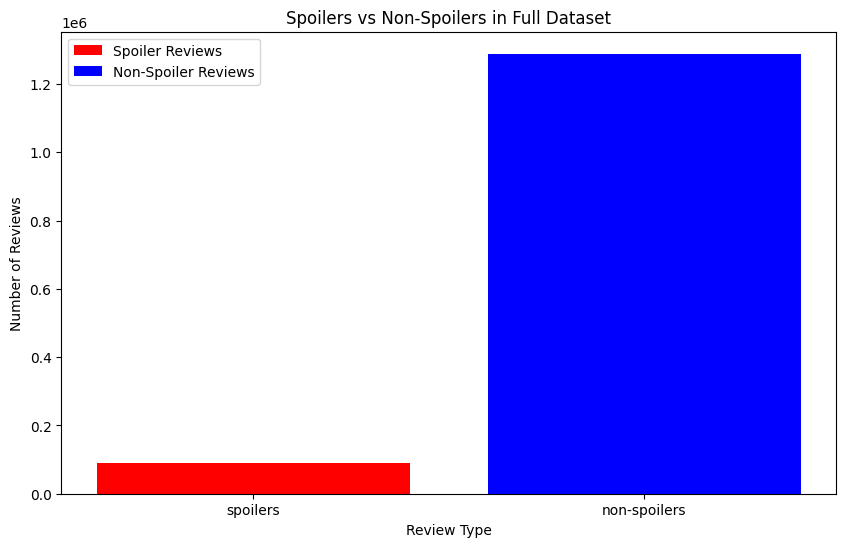

In [ ]:
## Spoilers vs Non-Spoilers in Dataset
fig, ax = plt.subplots(figsize=(10, 6))
num_spoilers = np.sum([1 for review in all_data if review['has_spoiler']])
num_non_spoilers = np.sum(1 for review in all_data if not review['has_spoiler'])
ax.bar("spoilers", num_spoilers, label='Spoiler Reviews', color='red')
ax.bar("non-spoilers", num_non_spoilers, label='Non-Spoiler Reviews', color='blue')

ax.set_xlabel('Review Type')
ax.set_ylabel('Number of Reviews')
ax.set_title('Spoilers vs Non-Spoilers in Full Dataset')
ax.legend()

In [ ]:
#Data Exploration printing
print("Number of spoilers in Training set", numSpoilerTrain )
print("Number of non spoilers in Training set", numNonSpoilerTrain )
print(f"Mean Review Rating for Spoilers: {mean_spoiler_rating}")
print(f"Mean Review Rating for Non-Spoilers: {mean_non_spoiler_rating}")
print(f"Mean sentence length for spoiler reviews: {mean_length_spoilers}")
print(f"Mean sentence length for non-spoiler reviews: {mean_length_non_spoilers}")


In [ ]:
# Spoilers by Users
sampled_users = user_review_stats.sample(50, random_state=2) #50 random users

users = sampled_users.index
spoiler_counts = sampled_users['num_spoiler']
non_spoiler_counts = sampled_users['num_non_spoiler']

x = np.arange(len(users))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(users, spoiler_counts, label='Spoiler Reviews', color='red')
ax.bar(users, non_spoiler_counts, bottom=spoiler_counts, label='Non-Spoiler Reviews', color='blue')

ax.set_xlabel('Users')
ax.set_ylabel('Number of Reviews')
ax.set_title('Total Reviews by User')
ax.legend()
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
# Spoilers by Books
book_review_stats = (
    train_df.groupby('book_id')
    .agg(num_spoiler=('has_spoiler', lambda x: sum(x == True)),
         num_non_spoiler=('has_spoiler', lambda x: sum(x == False)))
)


sampled_books = book_review_stats.sample(50, random_state=2) #50 random books

books = sampled_books.index
spoiler_counts = sampled_books['num_spoiler']
non_spoiler_counts = sampled_books['num_non_spoiler']

x = np.arange(len(books))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(books, spoiler_counts, label='Spoiler Reviews', color='red')
ax.bar(books, non_spoiler_counts, bottom=spoiler_counts, label='Non-Spoiler Reviews', color='blue')

ax.set_xlabel('Books')
ax.set_ylabel('Number of Reviews')
ax.set_title('Total Reviews by Book')
ax.legend()
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
#################################################
# Baseline Model                                #
#################################################

In [ ]:
# Test set from actual data distribution
randTestY = [d['has_spoiler'] for d in rand_test_data]
# Test set for equal amount of spoilers and non-spoilers
testY = [d['has_spoiler'] for d in testData]

In [ ]:
# predict false always
pred = []
for review in rand_test_data:
  pred.append(False)
accuracy = accuracy_score(randTestY, pred)
print("Accuracy:", accuracy)

Accuracy: 0.9346027691503875


In [ ]:
pred = []
for review in testData:
  pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

Accuracy: 0.5


In [ ]:
#################################################
# Ranking Books Based on Num of Spoilers        #
#################################################

In [ ]:
books = [d['book_id'] for d in rand_train_data]
books = set(books)
books = list(books)
spoilerReviewsPerBook = {d: [] for d in books}
for review in rand_train_data:
  if(review['has_spoiler']):
    spoilerReviewsPerBook[review['book_id']].append(review)

books = set(books)
books = list(books)
sorted_spoilersPerBook = sorted(spoilerReviewsPerBook.items(), key=lambda x: len(x[1]), reverse=True)
for book, spoilers in sorted_spoilersPerBook[:10]:
  print(f"Book ID: {book}, Number of Spoiler Sentences: {len(spoilers)}")
totalSpoilers = np.sum([len(spoilers) for _, spoilers in sorted_spoilersPerBook])
print(f"Total number of spoilers: {totalSpoilers}")

mostSpoiledBooks = []
spoilersCount = 0;
for book, spoilers in sorted_spoilersPerBook[-10:]:
  if(spoilersCount > totalSpoilers/2):
    break
  mostSpoiledBooks.append(book)
  spoilersCount += len(spoilers)
print(mostSpoiledBooks)

## predict
pred = []
for review in testData:
  if(review['book_id'] in mostSpoiledBooks):
    pred.append(True)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

pred = []
for review in rand_test_data:
  if(review['book_id'] in mostSpoiledBooks):
    pred.append(True)
  else:
    pred.append(False)
accuracy = accuracy_score(randTestY, pred)
print("Accuracy:", accuracy)

Book ID: 29056083, Number of Spoiler Sentences: 27
Book ID: 16096824, Number of Spoiler Sentences: 25
Book ID: 7260188, Number of Spoiler Sentences: 24
Book ID: 17927395, Number of Spoiler Sentences: 23
Book ID: 11870085, Number of Spoiler Sentences: 17
Book ID: 18692431, Number of Spoiler Sentences: 16
Book ID: 13206900, Number of Spoiler Sentences: 16
Book ID: 17347389, Number of Spoiler Sentences: 16
Book ID: 17383918, Number of Spoiler Sentences: 15
Book ID: 8755785, Number of Spoiler Sentences: 14
Total number of spoilers: 8630
['18046837', '31189134', '13484226', '23228', '17689281', '25223500', '107778', '11413298', '15814555', '49353']
Accuracy: 0.5
Accuracy: 0.9344866622159008


In [ ]:
books = [d['book_id'] for d in trainData]
books = set(books)
books = list(books)
spoilerReviewsPerBook = {d: [] for d in books}
for review in trainData:
  if(review['has_spoiler']):
    spoilerReviewsPerBook[review['book_id']].append(review)

In [ ]:
books = set(books)
books = list(books)
sorted_spoilersPerBook = sorted(spoilerReviewsPerBook.items(), key=lambda x: len(x[1]), reverse=True)
for book, spoilers in sorted_spoilersPerBook[:10]:
  print(f"Book ID: {book}, Number of Spoiler Sentences: {len(spoilers)}")
totalSpoilers = np.sum([len(spoilers) for _, spoilers in sorted_spoilersPerBook])
print(f"Total number of spoilers: {totalSpoilers}")


Book ID: 29056083, Number of Spoiler Sentences: 80
Book ID: 16096824, Number of Spoiler Sentences: 49
Book ID: 7260188, Number of Spoiler Sentences: 47
Book ID: 17927395, Number of Spoiler Sentences: 41
Book ID: 11235712, Number of Spoiler Sentences: 39
Book ID: 18692431, Number of Spoiler Sentences: 39
Book ID: 11870085, Number of Spoiler Sentences: 35
Book ID: 9460487, Number of Spoiler Sentences: 34
Book ID: 18710190, Number of Spoiler Sentences: 33
Book ID: 14061957, Number of Spoiler Sentences: 32
Total number of spoilers: 20000


In [ ]:
## the books that account for 50% of spoiler reviews are considered "most spoiled"
mostSpoiledBooks = []
spoilersCount = 0;
for book, spoilers in sorted_spoilersPerBook[-10:]:
  if(spoilersCount > totalSpoilers/2):
    break
  mostSpoiledBooks.append(book)
  spoilersCount += len(spoilers)
print(mostSpoiledBooks)

['6648020', '16309962', '8103107', '12628816', '49353', '2722413', '2924362', '23308148', '6314763', '15776704']


In [ ]:
# predict true if book is in mostSpoiledBooks
pred = []
for review in testData:
  if(review['book_id'] in mostSpoiledBooks):
    pred.append(True)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

pred = []
for review in rand_test_data:
  if(review['book_id'] in mostSpoiledBooks):
    pred.append(True)
  else:
    pred.append(False)
accuracy = accuracy_score(randTestY, pred)
print("Accuracy:", accuracy)

Accuracy: 0.4996
Accuracy: 0.9340657745783867


In [ ]:
pred = []
for review in testData:
  if(review['book_id'] in mostSpoiledBooks):
    pred.append(True)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

Accuracy: 0.5


In [ ]:
#################################################
# Spoilers Per Book                             #
#################################################

In [ ]:
books = [d['book_id'] for d in rand_train_data]
books = set(books)
books = list(books)
spoilersPerBook = {d: 0 for d in books}
reviewsPerBook = {d: [] for d in books}
for review in rand_train_data:
  if(review['has_spoiler']):
    spoilersPerBook[review['book_id']] += 1
  reviewsPerBook[review['book_id']].append(review)
for book in books:
  spoilersPerBook[book] = spoilersPerBook[book] / len(reviewsPerBook[book])

# predict
testY = [d['has_spoiler'] for d in testData]
pred = []
for review in testData:
  if(review['book_id'] in books):
    pred.append(spoilersPerBook[review['book_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Validation Accuracy:", accuracy)

# predict

pred = []
for review in rand_test_data:
  if(review['book_id'] in books):
    pred.append(spoilersPerBook[review['book_id']] >= 0.5)
  else:
    pred.append(False)

randTestY = [d['has_spoiler'] for d in rand_test_data]
accuracy = accuracy_score(randTestY, pred)
print("Test Accuracy:", accuracy)

Validation Accuracy: 0.514
Test Accuracy: 0.9174334562131723


In [ ]:
books = [d['book_id'] for d in trainData]
books = set(books)
books = list(books)
spoilersPerBook = {d: 0 for d in books}
reviewsPerBook = {d: [] for d in books}
for review in trainData:
  if(review['has_spoiler']):
    spoilersPerBook[review['book_id']] += 1
  reviewsPerBook[review['book_id']].append(review)
for book in books:
  spoilersPerBook[book] = spoilersPerBook[book] / len(reviewsPerBook[book])

# predict
testY = [d['has_spoiler'] for d in testData]
pred = []
for review in testData:
  if(review['book_id'] in books):
    pred.append(spoilersPerBook[review['book_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("number of reviews in test set with spoilers: ", np.sum(np.where(testY, 1, 0)))
print("Accuracy:", accuracy)

number of reviews in test set with spoilers:  2500
Accuracy: 0.524


In [ ]:
# predict

pred = []
for review in rand_test_data:
  if(review['book_id'] in books):
    pred.append(spoilersPerBook[review['book_id']] >= 0.5)
  else:
    pred.append(False)

randTestY = [d['has_spoiler'] for d in rand_test_data]
accuracy = accuracy_score(randTestY, pred)
print("number of reviews in test set with spoilers: ", np.sum(np.where(randTestY, 1, 0)))
print("Accuracy:", accuracy)

number of reviews in test set with spoilers:  4506
Accuracy: 0.6174857043336913


In [ ]:
#################################################
# Spoilers Per User                             #
#################################################

In [ ]:
## train on random train set

users = [d['user_id'] for d in rand_train_data]
users = set(users)
users = list(users)
spoilersPerUser = {d: 0 for d in users}
reviewsPerUser = {d: [] for d in users}

for review in rand_train_data:
  if(review['has_spoiler']):
    spoilersPerUser[review['user_id']] += 1
  reviewsPerUser[review['user_id']].append(review)
for user in users:
  spoilersPerUser[user] = spoilersPerUser[user] / len(reviewsPerUser[user])

# predict
pred = []
for review in testData:
  if(review['user_id'] in users):
    pred.append(spoilersPerUser[review['user_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

Accuracy: 0.5498


In [ ]:
# predict
pred = []
for review in rand_test_data:
  if(review['user_id'] in users):
    pred.append(spoilersPerUser[review['user_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(randTestY, pred)
# print("number of reviews in test set with spoilers: ", np.sum(np.where(randTestY, 1, 0)))
print("Accuracy:", accuracy)

Accuracy: 0.9238483643435604


In [ ]:
# calculates (# of spoilers)/(# of reviews) per user in the train dataset
# predicts true if > 0.5 for the user, if < 0.5 or the user hasn't been seen before predict false

users = [d['user_id'] for d in trainData]
users = set(users)
users = list(users)
spoilersPerUser = {d: 0 for d in users}
reviewsPerUser = {d: [] for d in users}

for review in trainData:
  if(review['has_spoiler']):
    spoilersPerUser[review['user_id']] += 1
  reviewsPerUser[review['user_id']].append(review)
for user in users:
  spoilersPerUser[user] = spoilersPerUser[user] / len(reviewsPerUser[user])

# predict
pred = []
for review in testData:
  if(review['user_id'] in users):
    pred.append(spoilersPerUser[review['user_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(testY, pred)
print("Accuracy:", accuracy)

number of reviews in test set with spoilers:  2500
Accuracy: 0.6696


In [ ]:
# predict
pred = []
for review in rand_test_data:
  if(review['user_id'] in users):
    pred.append(spoilersPerUser[review['user_id']] >= 0.5)
  else:
    pred.append(False)
accuracy = accuracy_score(randTestY, pred)
print("number of reviews in test set with spoilers: ", np.sum(np.where(randTestY, 1, 0)))
print("Accuracy:", accuracy)

number of reviews in test set with spoilers:  4506
Accuracy: 0.7033177556529564


In [ ]:
################################################################
# Word2Vec Model                                             #
#trademarked/pattented/copyright by Andrew Lu and friends    #
################################################################

In [ ]:
rand_train_df = pd.DataFrame(rand_train_data)

spoilersReview = rand_train_df[rand_train_df['has_spoiler'] == True]
print(spoilersReview.head())
spoilersData = []
for review in spoilersReview.itertuples():
  for sentence in review.review_sentences:
    label = int(sentence[0])
    text = sentence[1]
    spoilersData.append((text, label))
print(spoilersData[:10])
nltk.download('punkt_tab')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
ppData = []
for text,label in spoilersData:
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word.isalpha() and word not in stopWords]
  ppData.append((tokens, label))

sentences = [tokens for tokens, _ in ppData]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
x_train = []
y_train = []
for tokens, labels in ppData:
  vec = sentence_vector(tokens, model)
  x_train.append(vec)
  y_train.append(labels)
x_train = np.array(x_train)
y_train = np.array(y_train)


                             user_id   timestamp  \
1   314e2b5c96368d8d3d92f10d451f85f1  2013-12-20   
2   16df3e755aadb09f5abbe06fe06ce2d1  2017-01-11   
19  5575b4134bfb19926726616daf53bb19  2017-01-15   
25  dad0d3c7a8100bfb0b74c5d1d195ef6d  2017-06-06   
28  009a47e49c0dc6e84d1c5e0eb4cdf7f6  2016-03-02   

                                     review_sentences  rating  has_spoiler  \
1   [[0, 2+ stars], [0, I really liked the beginni...       2         True   
2   [[0, 2.5 stars.], [0, Do NOT read the spoiler ...       3         True   
19  [[0, Hm ... while this is still as compulsivel...       3         True   
25  [[0, Darkness never dies], [0, Hunted across t...       4         True   
28  [[0, I'm labelling these books as contemp roma...       4         True   

     book_id                         review_id  
1    5709572  d97220b61c241ecf2edbdfa7e5832197  
2   11405641  ecac9a92cd1285e7e4f8cd13c2ed5ea4  
19  26061581  bcba18908e8586e76ce99f1823e8f6a8  
25  18525661  638e89bc

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# preprocess testData
test_df = pd.DataFrame(testData)
testSpoilersReview = test_df[test_df['has_spoiler'] == True]
ppDataTest = []

testSpoilersData = []
for review in testSpoilersReview.itertuples():
  for sentence in review.review_sentences:
    label = int(sentence[0])
    text = sentence[1]
    testSpoilersData.append((text, label))

for text,label in testSpoilersData:
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word.isalpha() and word not in stopWords]
  ppDataTest.append((tokens, label))

x_test = []
y_test = []
for tokens, labels in ppDataTest:
  vec = sentence_vector(tokens, model)
  x_test.append(vec)
  y_test.append(labels)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7512196774630708


In [ ]:
## random test set

rand_test_df = pd.DataFrame(rand_test_data)
randTestSpoilersReview = rand_test_df[rand_test_df['has_spoiler'] == True]
ppRandDataTest = []

randTestSpoilersData = []
for review in randTestSpoilersReview.itertuples():
  for sentence in review.review_sentences:
    label = int(sentence[0])
    text = sentence[1]
    randTestSpoilersData.append((text, label))

for text,label in randTestSpoilersData:
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word.isalpha() and word not in stopWords]
  ppRandDataTest.append((tokens, label))

x_rand_test = []
y_rand_test = []
for tokens, labels in ppRandDataTest:
  vec = sentence_vector(tokens, model)
  x_rand_test.append(vec)
  y_rand_test.append(labels)
x_rand_test = np.array(x_rand_test)
y_rand_test = np.array(y_rand_test)



rand_y_pred = clf.predict(x_rand_test)
print("Accuracy:", accuracy_score(y_rand_test, rand_y_pred))

Accuracy: 0.7300750889210907


In [ ]:
## word2vec model
spoilersReview = train_df[train_df['has_spoiler'] == True]
print(spoilersReview.head())
spoilersData = []
for review in spoilersReview.itertuples():
  for sentence in review.review_sentences:
    label = int(sentence[0])
    text = sentence[1]
    spoilersData.append((text, label))
print(spoilersData[:10])
nltk.download('punkt_tab')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
ppData = []
for text,label in spoilersData:
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word.isalpha() and word not in stopWords]
  ppData.append((tokens, label))

                             user_id   timestamp  \
3   900c1edf2ede90f385872938ce6f16c9  2014-07-04   
20  4f5e21f30fb8399885b3a2dd913f7b07  2014-07-25   
26  2ab7669e560379b8ffeeb8f8e1f55fa3  2011-03-19   
30  c8c5b8df45ce7756f67cd348dd584f61  2017-08-10   
32  c38b4e3ae6d4d5082e09ab95689cb092  2014-06-29   

                                     review_sentences  rating  has_spoiler  \
3   [[0, This book features Michael, the man who d...       4         True   
20  [[0, Duke Leto Atreides knows Arrakis is a tra...       4         True   
26  [[1, ZOMG!], [1, I fell in love with this book...       5         True   
30  [[0, I quite enjoyed this book.], [0, But that...       4         True   
32  [[0, This is a coming of age story about Ruth ...       4         True   

     book_id                         review_id  
3   22370569  bf1dc58672a2e92a66ae117100356566  
20    234225  5db7c43f380762a5fee13202bd91d778  
26     13152  900b72395fb05ac331c8ffe369b3cf55  
30  18191460  bcdf2ab2

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sentences = [tokens for tokens, _ in ppData]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
x_train = []
y_train = []
for tokens, labels in ppData:
  vec = sentence_vector(tokens, model)
  x_train.append(vec)
  y_train.append(labels)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.729265483127795


In [ ]:
#################################################
# Combination: Spoiler Per User + Word2Vec      #
#################################################

In [ ]:
pred = []
for i in range(len(testData)):
  if(testData[i]['user_id'] in users):
    pred.append(spoilersPerUser[testData[i]['user_id']] >= 0.5)
  else:
    pred.append(clf.predict([x_test[i]])[0])
accuracy = accuracy_score(testY, pred)
print("Validation Accuracy:", accuracy)


pred = []
for i in range(len(rand_test_data)):
  if(rand_test_data[i]['user_id'] in users):
    pred.append(spoilersPerUser[rand_test_data[i]['user_id']] >= 0.5)
  else:
    pred.append(clf.predict([x_rand_test[i]])[0])
accuracy = accuracy_score(randTestY, pred)
print("Test Accuracy:", accuracy)

Validation Accuracy: 0.5522
Test Accuracy: 0.9222518939943688
